In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from PMASfunc import *
from scipy.stats import chisquare

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>5100*k) & (wo_wave<5130*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = ((wo_wave>4750*k) & (wo_wave<5090*k)) ^ ((wo_wave>4775*k) & (wo_wave<4783*k))    
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = ((wo_wave>4750*k) & (wo_wave<5090*k)) ^ ((wo_wave>4775*k) & (wo_wave<4783*k))    
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='black',label='data',drawstyle='steps-mid',lw = 3)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_data.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='--',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_BLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(wo_wave[select],fit,'r:',label='fit')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)


In [5]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)



In [6]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/PMAS"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    #print brightest_pixel_x,brightest_pixel_y
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    print (factor)
    error = factor*error
    #print (~np.isnan(error)).sum(0)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)

HE0853-0126
0.7129785
[ 3.21046748e-01  1.00501119e+00  1.78750621e+04  9.83100071e+01
 -6.54828105e-02  2.34235460e-01  1.76394647e+04  2.10561317e+02
  6.58929257e-01  1.57965166e-01  1.78725467e+04  3.26630537e+02
  1.30253791e-01  1.69135481e-02  1.75212556e+04  1.73625281e+03
  2.42410015e-01 -6.44842454e-01] [3.30354385e-02 2.93500639e-02 3.11649841e+00 3.74699710e+00
 5.29016223e-02 2.51129244e-02 2.40965655e+01 2.44478589e+01
 3.98840944e-02 6.62289761e-03 1.70265751e+01 1.36135520e+01
 6.73850436e-03 4.53945248e-03 7.83619417e+01 9.42872134e+01
 1.34625766e-02 7.05045174e-02]


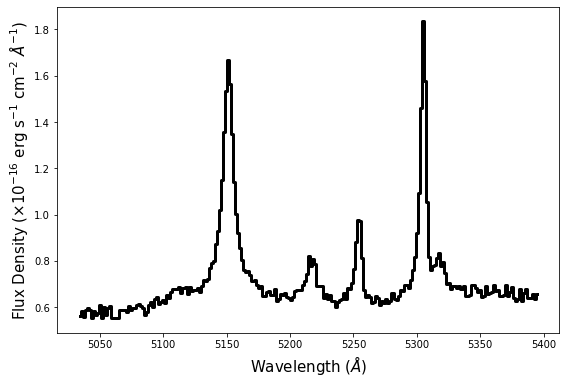

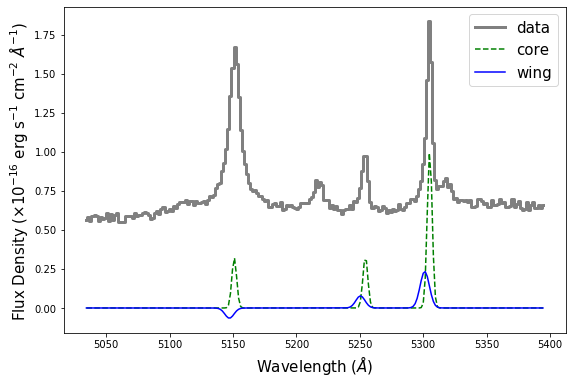

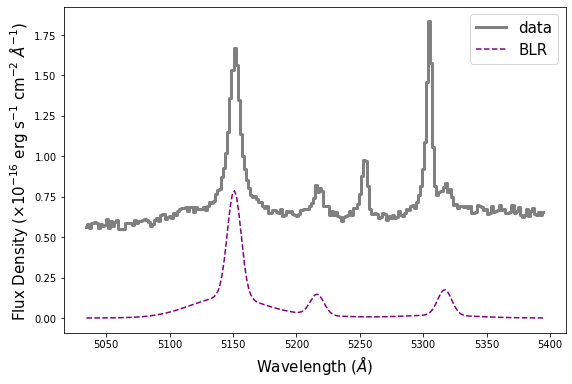

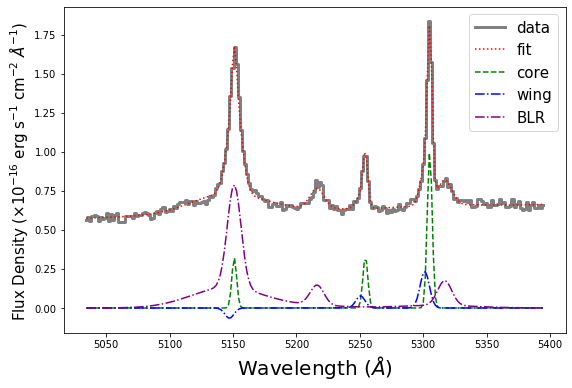

No handles with labels found to put in legend.


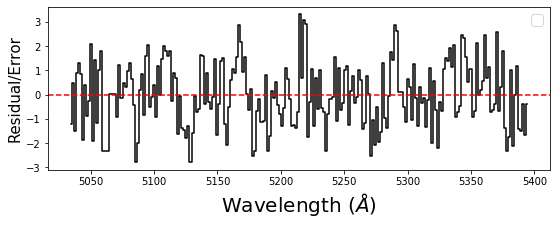

In [7]:
z = {"HE0853-0126":0.05981}#,"HE0949-0122":0.01993}

objs = z.keys()

broad2= {'HE0853-0126':True}

p_init= {'HE0853-0126':[0.1,1.0,17943.0,80.0,0.09,0.2,17843.0,200.0,1.0,0.1,17943.0,1000.0,0.2,0.1,17843.0,1500.0,-0.001,0.1]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE0949-0122
1.0717157
[ 6.55789909e+00  2.11980577e+01  5.85738145e+03  1.94011482e+02
  2.39782138e+00  7.34165355e+00  5.46583991e+03  4.92681158e+02
  4.92735339e+00  5.26708670e-01  5.98789067e+03  4.61160223e+02
  2.03433586e+00  2.47507751e+00  3.46927979e+03  2.15503808e+03
  7.07896788e+00 -3.33591814e+01] [ 0.20596839  0.17966145  1.45578339  1.90789521  0.19333509  0.15045693
  9.36317937  6.18670904  0.20441875  0.0392673  15.93127802 10.65696414
  0.12070026  0.07272009 27.17629101 36.15117058  0.50423791  2.617855  ]


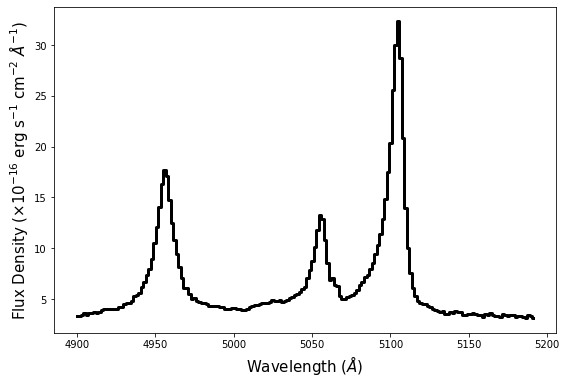

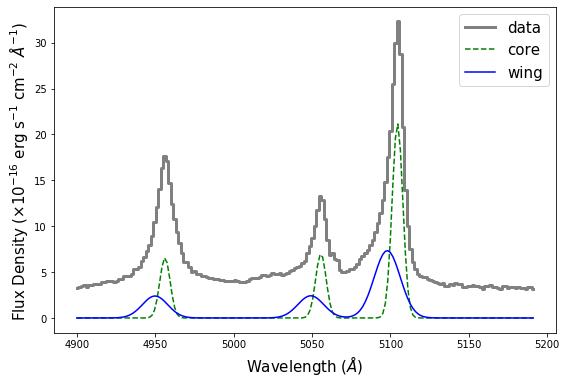

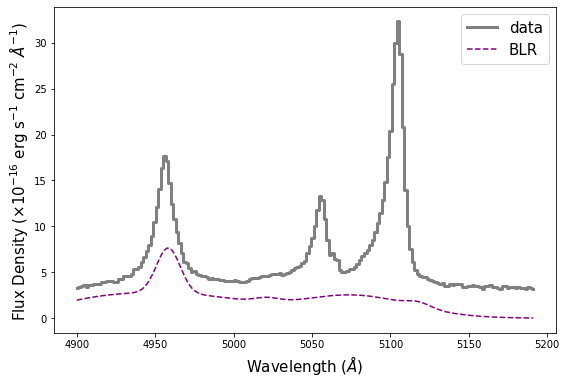

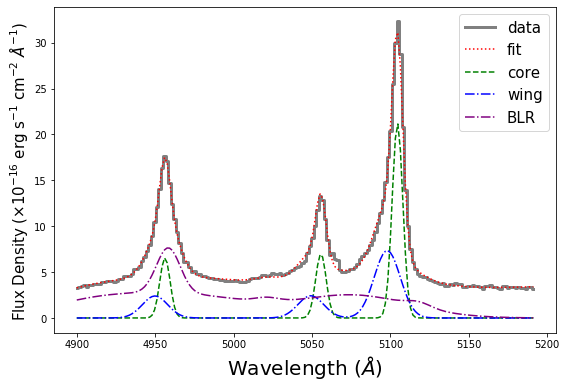

No handles with labels found to put in legend.


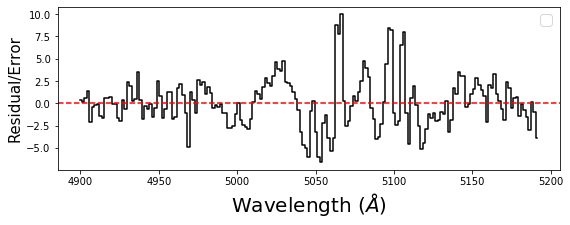

In [8]:
z = {"HE0949-0122":0.01993}

objs = z.keys()

broad2= {'HE0949-0122':True}

p_init= {'HE0949-0122':[5,15,5979.0,90.0,2,5,5779.0,200.0,7,2.0,5979.0,500.0,3,0.5,5979.0,1000.0,-0.001,2.0]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 